# Histogram Processing





> Gonzalez R. C. and Woods R. E. Digital Image Processing (Forth Edition).





令$r_k, k = 0, 1,2, \cdots, L-1$ 表示图片密度值为$k$, 
$$
h(r_k) = n_k, \: k = 0, 1, \cdots, L-1,
$$
整个图片$f(x, y)$中密度值为$r_k$的pixel的数量, 定义概率
$$
p(r_k) = \frac{h(r_k)}{MN} = \frac{n_k}{MN},
$$
其中$M, N$分别表示图片的高和宽(注意, 如果是多通道的图, 则应该$CMN$). 下图即为例子, 统计了$r_k$的分布.

![image-20210608174655216](https://i.loli.net/2021/06/08/HAxctVa86GsydjP.png)

In [67]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [68]:
pollen = cv2.imread("./pics/pollen.png")
pollen.shape # (377, 376, 3)

(377, 376, 3)

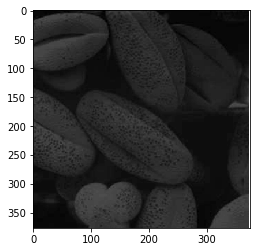

In [69]:
pollen = cv2.cvtColor(pollen, cv2.COLOR_BGR2GRAY) # 由于是截图, 先转成灰度图
pollen.shape # (377, 376)
plt.imshow(pollen, cmap='gray')

<BarContainer object of 256 artists>

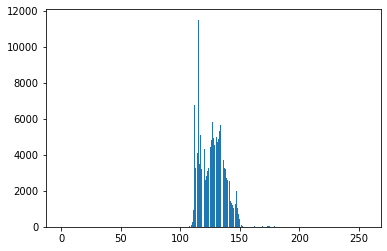

In [71]:
hist = cv2.calcHist([pollen], [0], None, [256], (0, 255)).squeeze()
plt.bar(x=np.arange(256), height=hist)

In [72]:
def equalizeHist(img):
    m, n = img.shape
    hist = cv2.calcHist([img], [0], None, [256], (0, 255)).squeeze() / (m * n)
    links = dict()
    cum_sum = 0
    for r in range(256):
        cum_sum += hist[r]
        links[r] = round(cum_sum * 255)
    img2 = img.copy()
    for i in range(m):
        for j in range(n):
            r = img[i, j].item()
            img2[i, j] = links[r]
    return np.array(img2)

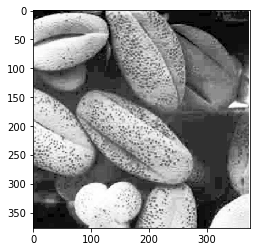

In [73]:
# 自定义
pollen2 = equalizeHist(pollen)
plt.imshow(pollen2, cmap='gray')

<BarContainer object of 256 artists>

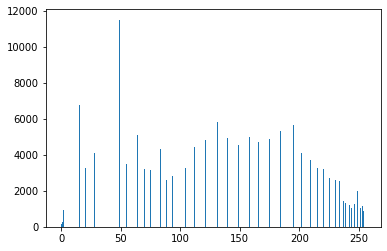

In [74]:
hist = cv2.calcHist([pollen2], [0], None, [256], (0, 255)).squeeze()
plt.bar(x=np.arange(256), height=hist)

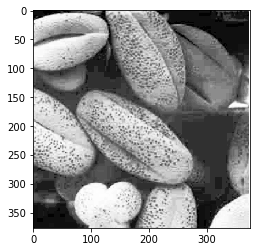

In [75]:
# cv2 官方实现
pollen3 = cv2.equalizeHist(pollen)
plt.imshow(pollen3, cmap='gray')

<BarContainer object of 256 artists>

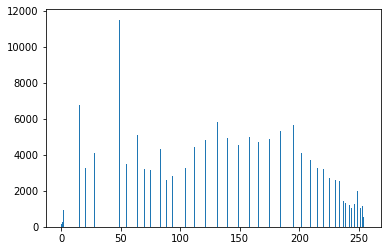

In [76]:
hist = cv2.calcHist([pollen3], [0], None, [256], (0, 255)).squeeze()
plt.bar(x=np.arange(256), height=hist)

## HISTOGRAM MATCHING (SPECIFICATION)



正如上面所说的, equalize只在连续的情况下是能够保证转换后的分布是均匀的, 当离散的时候, 实际上, 当分布特别聚集的时候, 出现的分布会与均匀相差甚远. 如下面的月球的表面图, 由于其分布集中在0附近, 导致变换后的图形并不能够很好的增加对比度(虽然能看清点).

![image-20210608201946617](https://i.loli.net/2021/06/08/X95PqGzFKh8IJEo.png)



![image-20210608202041719](https://i.loli.net/2021/06/08/awrpYQ6jgkDR14P.png)



此时, 我们可以预先指定一个分布$p_z$, 回顾:
$$
s = T(r) = (L-1) \int_0^r p_r (w) \mathrm{d} w,
$$
我们将$s \rightarrow z$:
$$
s = G(z) = (L-1) \int_0^z p_z (v) \mathrm{d} v,
$$
$T(r) = s =G(z)$, 既然在连续的情况下$s$是均匀的, 故
$$
z = G^{-1} T(r),
$$
当然需要一个额外的假设$G$是可逆的. 如此, 我们变把$r$转换成了我们期待的分布$z$.



那么在离散的情况下, 处理流程如下:



1. 通过
   $$
   T(r_k), \: k = 0, 1, \cdots, L-1,
   $$
   建立字典
   $$
   d_{rs}=\{r_k:\mathrm{round}(T(r_k))\}.
   $$
   

2.  通过
   $$
   G(z_k), \: k = 0, 1, \cdots, L-1,
   $$
   对于每一个$s_k$, 从$z_j, j=0,1,\cdots, L-1$中找到一个$z_j$使得$G(z_j)$与$s_k$最接近, 并建立字典
   $$
   d_{sz} = \{s_k:z_j\}.
   $$

3.  $r \rightarrow z$:
   $$
   z = d_{sz}[d_{rs}[r]].
   $$



在实际中, 一般取原图$r$分布一个光滑近似, 如下图所示(个人觉得, 此处核密度函数估计大有可为):



![image-20210608203627329](https://i.loli.net/2021/06/08/eZmVzjPl58qRgIK.png)

## 其它



有些时候, 我们只需要对一部分的区域进行上述的处理, 就是LOCAL HISTOGRAM PROCESSING.

 另外, 可以用一些统计信息来处理, 比如常见的矩
$$
\mu_n = \sum_{i=0}^{L-1} (r_i-m)^n p(r_i), \\
m = \sum_{i=0}^{L-1}r_i p(r_i),
$$
这里$m$是均值. 常用的二阶矩, 方差:
$$
\sigma^2 = \sum_{i=0}^{L-1} (r_i - m)^2 p(r_i),
$$
是图片对比度的一种衡量的手段.

对于以$(x, y)$为中心的区域, 也可以各自定义其矩$\mu_{S_{xy}}$. 下图就是通过区域的一阶矩和二阶矩的信息来让黑色部分的对比度增加.

![image-20210608204514406](https://i.loli.net/2021/06/08/VdHzg2xLtEklinS.png)



